In [1]:
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using NeuralOperators, Lux, Optimisers, Zygote
using Statistics  
using ConcreteStructs                        # for `mean` function

In [2]:
#create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
C = randn(obs_dim, latent_dim)
R = Matrix(0.5 * I(10))


# create the state-space model
true_ssm = GaussianLDS(;A=A, 
                        Q=Q, 
                        C=C, 
                        R=R, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, Y = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes
     

([-0.17266718174759607 -0.49817651858843515 … 0.7901142481696322 0.1535078832875531; 0.08766755090171895 0.02737378246797314 … 0.4040159347045844 0.9778523304678008;;;], [0.010781157074869124 -0.3015163619936472 … 0.3925441341729364 0.7711498126204774; -0.5483675845638685 -1.8556548541063682 … 0.5843564354659168 0.11562804019783335; … ; 1.6877370637420273 0.2265508885826456 … -0.5944093423576039 0.5357593219685761; 0.48889536889325946 -0.09249047339299457 … -0.7689412380713057 -0.5603834344500751;;;])

In [4]:
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(true_ssm, Y)

([-0.2895429413933743 -0.7702286802054724 … 0.7459941660309443 0.5163798829562288; 0.2080438037223241 -0.03687891639780408 … 0.35981024534702916 0.7486421270693052;;;], [0.034372703806220345 -0.005796321492183539; -0.005796321492183539 0.02653080901059158;;; 0.03847175808465816 -0.007065684261130636; -0.007065684261130636 0.02827036378800226;;; 0.03898191408173492 -0.007212230804399616; -0.007212230804399616 0.028380442655785824;;; … ;;; 0.03918475351444236 -0.0073189574992031554; -0.0073189574992031554 0.028470538057983413;;; 0.0403786613804342 -0.007879418750986932; -0.007879418750986932 0.029035742149522436;;; 0.051553992434943505 -0.010456746594366646; -0.010456746594366646 0.03476643046988238;;;;], [0.0 0.0; 0.0 0.0;;; 0.011184409011624433 -0.005313789749498953; -0.001185006676795441 0.00678826932700434;;; 0.012595736515988363 -0.005931454705744107; -0.001475382869611583 0.007225351526316247;;; … ;;; 0.012834485468475716 -0.006031917772721812; -0.0015397959414069748 0.007283203844

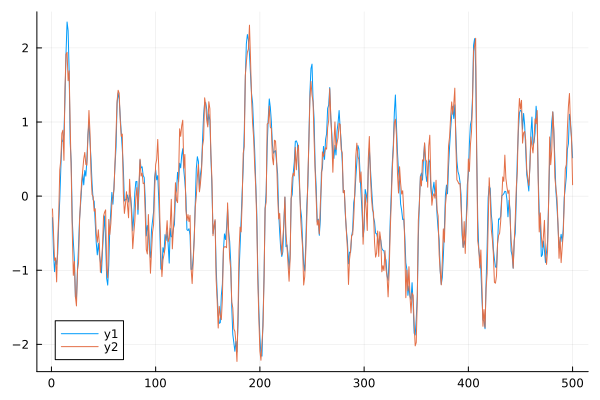

In [16]:
plot(x_smooth[1,:,1])
plot!(latents[1,:,1])

In [17]:
latent_dim = 2             # desired latent state dimension
width = 32                 # FNO channel width
depth = 4                  # number of Fourier layers
modes = 8                  # number of Fourier modes
tin = size(Y, 1)           # observation dimension
T = size(Y,2)

500

In [100]:
y = reshape(Y, T, tin, 1)
y = Float32.(y);

In [19]:
# ---------------------------------------------------
# 2) Build encoder & decoder
# ---------------------------------------------------
width = 32; depth = 4; modes = 8
chs_enc = (tin, fill(width, depth)..., latent_dim)
chs_dec = (latent_dim, fill(width, depth)..., tin)
encoder = FourierNeuralOperator(elu; chs=chs_enc, modes=(modes,), permuted=Val(true))
decoder = FourierNeuralOperator(elu; chs=chs_dec, modes=(modes,), permuted=Val(true))

FourierNeuralOperator(
    model = Chain(
        layer_1 = Conv((1,), 2 => 32),  # 96 parameters
        layer_2 = Chain(
            layer_1 = OperatorKernel(
                layer = Parallel(
                    connection = Fix1(add_act, elu),
                    layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                    layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                ),
            ),
            layer_2 = OperatorKernel(
                layer = Parallel(
                    connection = Fix1(add_act, elu),
                    layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                    layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                ),
            ),
        ),
        layer_3 = Chain(
            layer_1 = Conv((1,), 32 => 32, elu),  # 1_056 parameters
            layer_2 = Conv((1,), 32 => 1

In [101]:
# ---------------------------------------------------
# 3) Setup parameters, state, optimizers
# ---------------------------------------------------
rng = Random.default_rng()
params_dec, state_dec = Lux.setup(rng, decoder)
params_enc, state_enc = Lux.setup(rng, encoder)


((layer_1 = (weight = Float32[-0.40469888 0.01828097 … -0.42886496 0.48754016;;; -0.014726256 0.017777491 … 0.2698835 -0.43112177;;; 0.023042833 -0.33697668 … -0.020601114 -0.036158036;;; … ;;; -0.15517119 0.43136996 … 0.4390153 -0.15804456;;; -0.024335451 -0.32557255 … 0.26174918 0.035813022;;; -0.12555347 -0.14177679 … -0.17320254 0.20230769], bias = Float32[-0.08400701, -0.1647857, -0.012437541, -0.14329316, -0.25580737, 0.15761504, -0.023498077, -0.30567732, 0.18957227, 0.18944833  …  0.1606249, 0.23748785, -0.069414996, -0.00021860657, 0.2615038, 0.26367703, -0.19886981, 0.23621176, 0.18292469, -0.00043457432]), layer_2 = (layer_1 = (layer_1 = (weight = Float32[-0.061783817 -0.06672106 … -0.24176037 0.17544794;;; 0.2692619 0.09473492 … 0.24083163 -0.27226448;;; 0.24604157 0.21760689 … -0.15189916 -0.091523774;;; … ;;; -0.1674526 0.28410482 … -0.09867574 0.22463688;;; -0.2800779 0.13650715 … -0.08585879 0.13048282;;; -0.17885363 0.2605413 … -0.06236833 -0.13615857], bias = Float32[

In [102]:
# forward pass via Lux.apply: returns latent sequence and updated state
z, st = Lux.apply(encoder, y, params_enc, state_enc)

# latent_seq has shape (spatial, out_ch, batch) i.e. (T, latent_dim, 1)
println("Encoded latent sequence size: ", size(z))

Encoded latent sequence size: (500, 2, 1)


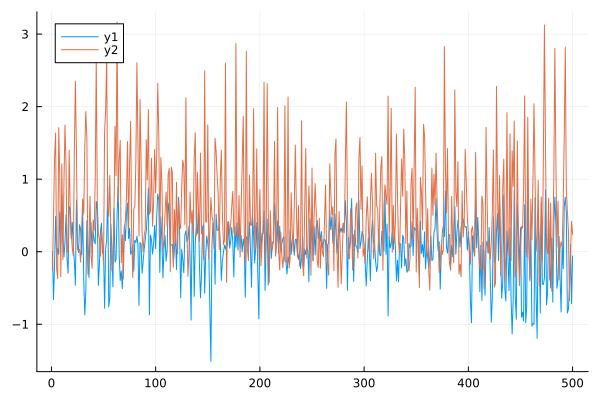

In [103]:
plot(z[:,:,1])

In [104]:
x_rec, st_dec = Lux.apply(decoder, latent_seq, params_dec, state_dec)

(Float32[-0.26483345 0.46705493 … 0.10024643 0.37760648; -0.14165679 0.811256 … 0.4915106 0.25922623; … ; -0.14148098 1.014544 … 0.69253016 0.2584728; 0.5172555 -0.2827895 … -1.1503805 0.90098584;;;], (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())))

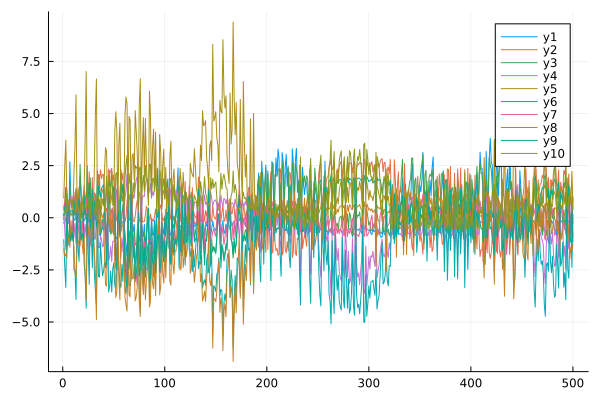

In [105]:
plot(x_rec[:,:,1])

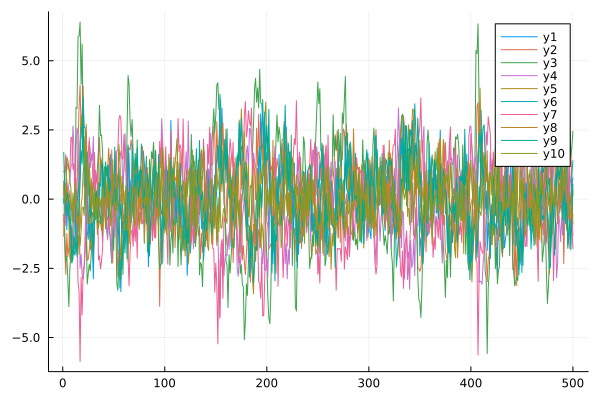

In [106]:
plot(Y[:,:,1]')

## Combine

In [107]:
@concrete struct VAE <: Lux.AbstractLuxContainerLayer{(:encoder, :decoder)}
    encoder <: Lux.AbstractLuxLayer
    decoder <: Lux.AbstractLuxLayer
end

In [108]:
function (vae::VAE)(x, ps, st)
    z, st_enc = Lux.apply(vae.encoder, y, ps.encoder, st.encoder)
    x_rec, st_dec = Lux.apply(vae.decoder, z, ps.decoder, st.decoder)
    #(z, μ, logσ²), st_enc = vae.encoder(x, ps.encoder, st.encoder)
    #return (x_rec, μ, logσ²), (; encoder=st_enc, decoder=st_dec)
    return (x_rec, z), (; encoder=st_enc, decoder=st_dec)
end

In [109]:
vae = VAE(encoder, decoder)

VAE(
    encoder = FourierNeuralOperator(
        model = Chain(
            layer_1 = Conv((1,), 10 => 32),  # 352 parameters
            layer_2 = Chain(
                layer_1 = OperatorKernel(
                    layer = Parallel(
                        connection = Fix1(add_act, elu),
                        layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                        layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                    ),
                ),
                layer_2 = OperatorKernel(
                    layer = Parallel(
                        connection = Fix1(add_act, elu),
                        layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                        layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                    ),
                ),
            ),
            layer_3 = Chain(
            

In [110]:
ps, st = Lux.setup(rng, vae)

((encoder = (layer_1 = (weight = Float32[-0.1256304 -0.25446156 … -0.057860065 0.16801013;;; 0.44013777 -0.36634797 … -0.26440153 -0.31862238;;; 0.31809926 0.4901549 … 0.47880366 -0.2751841;;; … ;;; 0.42314348 0.4555861 … -0.13082986 -0.2125629;;; -0.384008 0.5115131 … -0.31700256 0.06090588;;; -0.4319179 -0.2783302 … 0.34255472 -0.18489179], bias = Float32[0.064437255, -0.18101491, 0.17309539, 0.22483115, -0.14939447, 0.29645583, 0.09887847, 0.08856265, -0.14805953, 0.10064659  …  -0.29375082, 0.19478223, -0.095284946, -0.041576188, 0.26707673, 0.19770916, 0.21593828, -0.21002455, -0.28705424, -0.03799585]), layer_2 = (layer_1 = (layer_1 = (weight = Float32[-0.2879708 -0.013651018 … 0.22043157 -0.06829513;;; -0.10412603 -0.18777622 … -0.09665589 0.1297688;;; -0.0446752 0.17482127 … 0.25099513 0.15052627;;; … ;;; -0.20173009 0.088757604 … -0.26713198 -0.032720312;;; 0.21980084 -0.19260211 … -0.08372634 0.2721441;;; -0.048821595 0.29560626 … -0.20051554 -0.19876912], bias = Float32[-0.1

In [111]:
vae(y, ps, st)

((Float32[-0.39982617 0.33027658 … -0.44282517 -0.66700184; 0.12212306 0.48589823 … -0.541604 -0.63216084; … ; -0.07802209 0.37441465 … -0.5996841 -0.49034727; -0.0147711225 0.55274147 … -0.46228322 -0.745329;;;], Float32[0.061250333 -0.065966144; -0.26743144 0.41456386; … ; -0.4000482 0.039727654; 0.021388553 0.5089096;;;]), (encoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()))))

In [112]:
opt = AdamW()

AdamW(eta=0.001, beta=(0.9, 0.999), lambda=0.0, epsilon=1.0e-8, couple=true)

In [114]:
function loss_function(model, ps, st, y)
    (x_rec, z), st = model(y, ps, st)
    reconstruction_loss = MSELoss(; agg=sum)(x_rec, y)
    kldiv_loss = 0
    loss = reconstruction_loss + kldiv_loss
    return loss, st, (; y, z, kldiv_loss, reconstruction_loss)
    #(y, μ, logσ²), st = model(X, ps, st)
    #kldiv_loss = -sum(1 .+ logσ² .- μ .^ 2 .- exp.(logσ²)) / 2
    #return loss, st, (; y, μ, logσ², reconstruction_loss, kldiv_loss)
end

loss_function (generic function with 1 method)

In [115]:
loss_function(vae, ps, st, y)

(10839.372f0, (encoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()))), (y = Float32[0.010781157 0.11457076 … -0.7741639 -1.942314; -0.54836756 0.12684804 … -1.324949 1.0554959; … ; 0.18283154 -0.7500329 … -1.497508 0.5357593; 0.15602423 -0.7138555 … -0.058311466 -0.56038344;;;], z = Float32[0.061250333 -0.065966144; -0.26743144 0.41456386; … ; -0.4000482 0.039727654; 0.021388553 0.5089096;;;], kldiv_loss = 0, reconstruction_loss = 10839.372f0))

In [116]:
train_state = Training.TrainState(vae, ps, st, opt)

TrainState
    model: VAE{FourierNeuralOperator{Chain{@NamedTuple{layer_1::Conv{typeof(identity), Int64, Int64, Tuple{Int64}, Tuple{Int64}, Tuple{Int64, Int64}, Tuple{Int64}, Int64, Nothing, Nothing, Static.True, Static.False}, layer_2::Chain{@NamedTuple{layer_1::OperatorKernel{Parallel{NeuralOperators.Fix1{typeof(NeuralOperators.add_act), typeof(elu)}, @NamedTuple{layer_1::Conv{typeof(identity), Int64, Int64, Tuple{Int64}, Tuple{Int64}, Tuple{Int64, Int64}, Tuple{Int64}, Int64, Nothing, Nothing, Static.True, Static.False}, layer_2::OperatorConv{Static.True, FourierTransform{ComplexF32, Tuple{Int64}}, typeof(glorot_uniform)}}, Nothing}}, layer_2::OperatorKernel{Parallel{NeuralOperators.Fix1{typeof(NeuralOperators.add_act), typeof(elu)}, @NamedTuple{layer_1::Conv{typeof(identity), Int64, Int64, Tuple{Int64}, Tuple{Int64}, Tuple{Int64, Int64}, Tuple{Int64}, Int64, Nothing, Nothing, Static.True, Static.False}, layer_2::OperatorConv{Static.True, FourierTransform{ComplexF32, Tuple{Int64}}, 

In [117]:
losses = Float32[]

Float32[]

In [118]:
for epoch in 1:500
    (_, loss, _, train_state) = Training.single_train_step!(
        AutoZygote(), loss_function, y, train_state; return_gradients=Val(false)
    )
    push!(losses, loss)
end

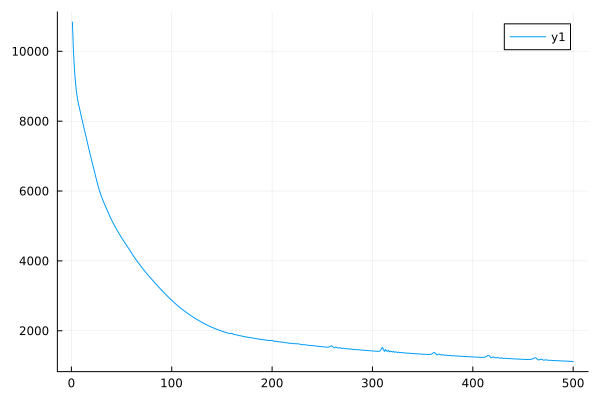

In [119]:
plot(losses)

In [120]:
loss_function(vae, ps, st, y)

(1121.1619f0, (encoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()))), (y = Float32[0.010781157 0.11457076 … -0.7741639 -1.942314; -0.54836756 0.12684804 … -1.324949 1.0554959; … ; 0.18283154 -0.7500329 … -1.497508 0.5357593; 0.15602423 -0.7138555 … -0.058311466 -0.56038344;;;], z = Float32[-8.18109 1.8312056; -11.259784 -0.9085489; … ; -11.242017 0.6438656; -6.4925427 2.5904818;;;], kldiv_loss = 0, reconstruction_loss = 1121.1619f0))

In [121]:
(recon_seq, latent_seq), st = vae(y, ps, st)

((Float32[-0.065034345 -0.12797457 … -0.7005151 -1.1587915; 0.105489306 0.57414746 … -1.5895311 0.8845805; … ; 0.3715223 -0.38756615 … -1.8130739 0.5439547; -0.12533219 -0.12279924 … 0.05477529 -1.4428726;;;], Float32[-8.18109 1.8312056; -11.259784 -0.9085489; … ; -11.242017 0.6438656; -6.4925427 2.5904818;;;]), (encoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()))))

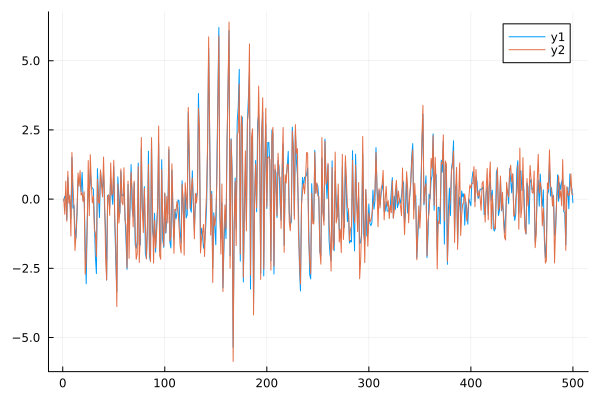

In [122]:
plot(recon_seq[:,1,1])
plot!(y[:,1,1])

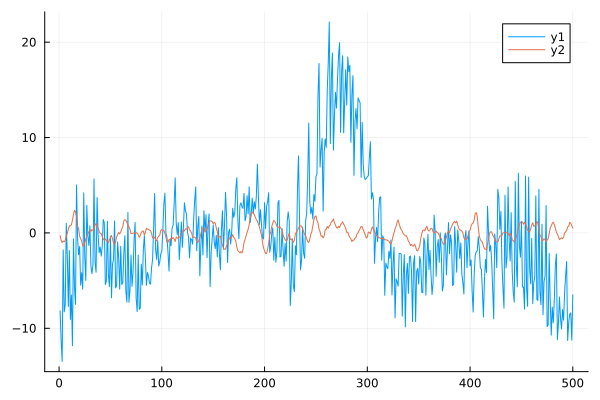

In [123]:
plot(latent_seq[:,1,1])
plot!(x_smooth[1,:,1])